In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using BenchmarkTools

In [2]:
# ENV["JULIA_DEBUG"] = "BAT"

In [3]:
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BenchmarkTools

In [4]:
# using Revise
using BAT 

# Low `p` Population: 

In [ ]:
# conv_mat = load("../data/experiment/dataset_2/m1/conv-matrix-upd-1.jld2")

# conv_matrices = (
#     cam_1 = conv_mat["cam_1"],
#     cam_2 = conv_mat["cam_2"],
#     cam_3 = conv_mat["cam_3"],
#     cam_4 = conv_mat["cam_4"], 
# )

# images = load("../data/experiment/dataset_2/m1/images-satur.jld2");
# event_number = 343

# # Small Charge: Ev_1_3 = 343, Ev_1_1 = 137, Ev_1_2 = 9

# event = (
#     cam_1 = images["cam_1"][event_number,:,:],
#     cam_2 = images["cam_2"][event_number,:,:],
#     cam_3 = images["cam_3"][event_number,:,:],
#     cam_4 = images["cam_4"][event_number,:,:],
#     population = images["charge"][event_number,:][1],
# );

# High `p` Population: 

In [5]:
conv_mat = load("../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2")

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"], 
) 

images = load("../data/experiment/dataset_2/m2/images-satur.jld2");
event_number = 2

# Large Charge: Ev_2_2 = 2, Ev_2_1 = 311, Ev_2_3 = 440

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);


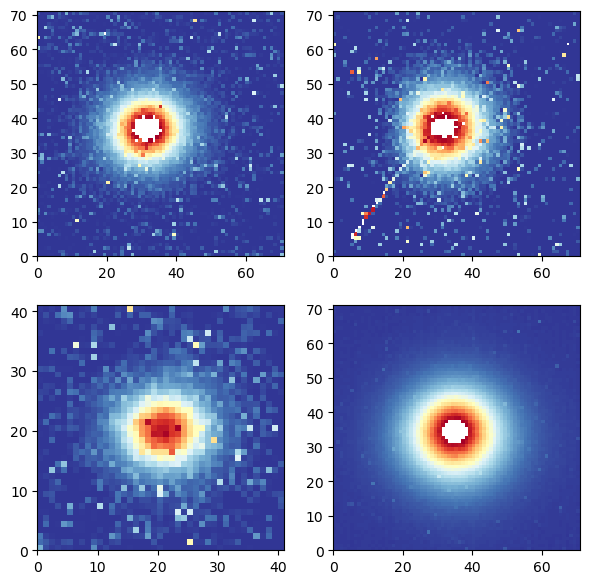

PyObject <matplotlib.collections.QuadMesh object at 0x7f9e4ac0df70>

In [6]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

In [7]:
include("../src/likelihood.jl")
include("../src/utill.jl")

corner_plots (generic function with 1 method)

In [8]:
"""
    Log-Likelihood of the beamline (4 cameras included)
"""
function log_lik_ndiff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_discrete,
    cv_1 = cv_mat.cam_1,
    cv_2 = cv_mat.cam_2,
    cv_3 = cv_mat.cam_3,
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        return LogDVal(ll)
    end
        
end

function log_lik_diff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_cont,
    cv_1 = exp.(cv_mat.cam_1),
    cv_2 = exp.(cv_mat.cam_2),
    cv_3 = exp.(cv_mat.cam_3),
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        
        return LogDVal(ll)
    end
    
end

# log_likelihood = log_lik_diff()

log_likelihood = log_lik_ndiff()

#23 (generic function with 1 method)

In [ ]:
# param_truth = (
#         tr_size = [0.2, 0.2],
#         ang_spr = [4.0, 4.0],
#         waist = [2.9,],
#         algmx = [35,35,20,35], 
#         algmy = [35,35,20,35], 
#         cam4_ped = 34.3,
#         cam4_light_fluct = 2.15,
#         cam4_light_amp = event.population*32.16870*10^-2,
#         resx = [0, 0, 0], 
#         resy = [0, 0, 0], 
#         cam4_resx = 0,
#         cam4_resy = 0,
#         psx = [27.1,21.6,114.], 
#         psy = [30.5,23.4,125.],
#         cam4_psx = 90.9, #3*0.0303*10^3,
#         cam4_psy = 89.4, #3*0.0298*10^3,
#         light_amp  = [event.population*35.14744*10^-2, event.population*50.23506*10^-2, event.population*10.09664*10^-2],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );

In [9]:
# β = 0.015

β1 = 0.015
β2 = 0.008
β3 = 0.006

# flat prior for the pixel size
prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4.0, 2.0), 2.0, 6.0), truncated(Normal(4.0, 2.0), 2.0, 6.0)],
        waist = [Normal(2.9, 0.03)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
        psx = [truncated(Normal(27.1, 27.1*β1), 0., Inf), truncated(Normal(21.6, 21.6*β1), 0., Inf), truncated(Normal(114.0, 114.0*β2), 0., Inf)], # pixels are in microns
        psy = [truncated(Normal(30.5, 30.5*β1), 0., Inf), truncated(Normal(23.4, 23.4*β1), 0., Inf), truncated(Normal(125.0, 125.0*β2), 0., Inf)],
        cam4_psx = truncated(Normal(121.8, 3*121.8*β3), 0., Inf), # original Pixel size (smaller) 91.0; Updated Pixel size (larger) 121.2
        cam4_psy = truncated(Normal(120.0, 3*120.0*β3), 0., Inf), # original Pixel size (smaller) 89.4; Updated Pixel size (larger) 120.6
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    ); 

In [10]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMHTuning(
    λ = 0.5,
    α = ClosedInterval(0.15,0.25),
    β = 1.5,
    c = ClosedInterval(1e-4,1e2),
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCChainPoolInit(
    init_tries_per_chain = ClosedInterval(50,150),
    max_nsamples_init = 500,
    max_nsteps_init = 500,
    max_time_init = Inf
)

burnin = MCMCMultiCycleBurnin(
    max_nsamples_per_cycle = 5000,
    max_nsteps_per_cycle = 5000,
    max_time_per_cycle = Inf,
    max_ncycles = 130
)

nsamples = 1*10^5
nchains = 4

sampler = MetropolisHastings(tuning=tuning,)

algorithm = MCMCSampling(sampler=sampler, 
    nchains=nchains, 
    init=init, 
    burnin=burnin, 
    convergence=convergence
);

In [11]:
# log_likelihood(param_truth)
# @benchmark log_likelihood(param_truth)

In [12]:
@time samples_tot = bat_sample(
    posterior, nchains*nsamples, algorithm,
    max_neval = nchains*nsamples,
    max_time = Inf,
);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:63
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:185
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/s

2034.228404 seconds (1.31 G allocations: 774.877 GiB, 7.23% gc time)


In [13]:
samples = samples_tot.result;

In [14]:
minimum(bat_eff_sample_size(unshaped.(samples)).result)

147.082002061118

In [15]:
size(flatview(unshaped.(samples.v)))

(35, 81002)

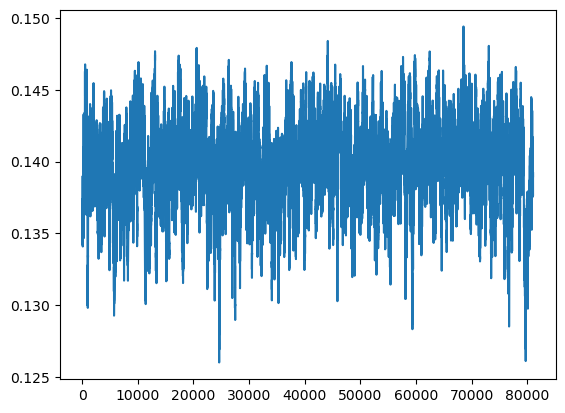

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9d85cc4d60>

In [16]:
plot(flatview(unshaped.(samples.v))[1,:])

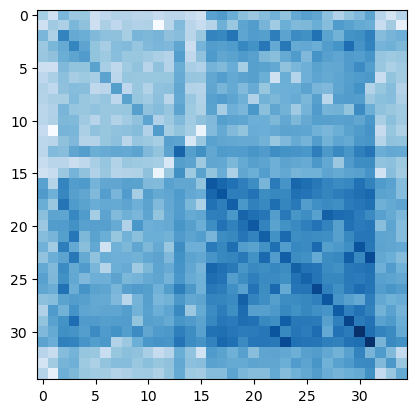

PyObject <matplotlib.image.AxesImage object at 0x7f9d85dda700>

In [17]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

In [31]:
# BAT.bat_write("../data/sampling_results/MultipleEvents-2/mcmc-samples-1-3.hdf5", unshaped.(samples))

# BAT.bat_write("../data/sampling_results/To_delete/new_cv.hdf5", unshaped.(samples))

In [18]:
mode(samples)[1]

(tr_size = [0.14075380316168545, 0.13523350649283836], ang_spr = [3.7091029870740475, 4.873727446777229], waist = [2.8993239652955505], algmx = [36.95040106964175, 37.431431678196326, 20.19652040102917, 33.826869490281666], algmy = [31.74211037406037, 32.21345472080728, 21.224873235382862, 35.2450454356032], cam4_ped = 33.44717893290975, cam4_light_fluct = 1.9959897265458448, cam4_light_amp = 8.39128262321829, resx = [0.9616543434329613, 1.0500505118404129, 1.348123628180403], resy = [3.030671985768783, 0.7653332465865291, 0.45806030120484453], cam4_resx = 6.499140884711228, cam4_resy = 4.448217549095186, psx = [26.29575356914129, 21.672321095663303, 115.06735247033183], psy = [29.40531255447371, 23.882296000328058, 126.26478959937782], cam4_psx = 120.83374943220015, cam4_psy = 118.68260814111738, light_amp = [8.249283410585518, 11.428768344022627, 2.575001846468003], s_cam = [0.0, 1.478, 15.026, 23.115])

In [19]:
bat_marginalmode(samples).result

ShapedAsNT((tr_size = [0.1405, 0.1343], ang_spr = [3.8425000000000002, 4.8575], waist = [2.9210000000000003], algmx = [36.951499999999996, 37.430499999999995, 20.174500000000002, 33.840500000000006], algmy = [31.750500000000002, 32.213499999999996, 21.238999999999997, 35.2555], cam4_ped = 33.485, cam4_light_fluct = 2.0015, cam4_light_amp = 8.3995, resx = [1.43, 1.11, 0.755], resy = [3.215, 0.65, 0.565], cam4_resx = 6.335, cam4_resy = 4.609999999999999, psx = [26.729999999999997, 21.810000000000002, 114.275], psy = [29.47, 23.79, 125.625], cam4_psx = 121.85, cam4_psy = 119.35, light_amp = [8.241, 11.433, 2.5805], s_cam = [0.0, 1.478, 15.026, 23.115]))

In [20]:
mean(samples)[1]

(tr_size = [0.13968887746810638, 0.13324503477902117], ang_spr = [3.81312336628479, 4.837101624725269], waist = [2.920308045238757], algmx = [36.94767892530256, 37.42715028350741, 20.17933823085778, 33.842113129555834], algmy = [31.74905943305807, 32.21382519097084, 21.241405664458046, 35.25693245077058], cam4_ped = 33.57720143857529, cam4_light_fluct = 2.003180168208855, cam4_light_amp = 8.400928959661721, resx = [1.329768812056164, 1.0507108090302621, 0.7908991050152346], resy = [3.2712019072746066, 0.8447349064147976, 0.625282342546918], cam4_resx = 6.350202982300162, cam4_resy = 4.64435313495968, psx = [26.782029470222074, 21.78645248467565, 114.2702532869398], psy = [29.61848945967403, 23.80555851667804, 125.49984069677943], cam4_psx = 121.39764316732354, cam4_psy = 119.31735396592771, light_amp = [8.240414887404684, 11.427551355875215, 2.577178604137471], s_cam = [0.0, 1.478, 15.026, 23.115])

In [21]:
std(samples)[1]

(tr_size = [0.002976898311230211, 0.0035043748514533516], ang_spr = [0.08051466655437224, 0.07603362323145024], waist = [0.028896557433587634], algmx = [0.022024383746916735, 0.02090810285596419, 0.0258411295005695, 0.02227529321712166], algmy = [0.024454134867022383, 0.019647583291939497, 0.028871264113745493, 0.023436550339810434], cam4_ped = 0.2815799622019496, cam4_light_fluct = 0.020704732198663315, cam4_light_amp = 0.021373144107441195, resx = [0.460116834121392, 0.5410712184993958, 0.35304376969255724], resy = [0.2805920566844356, 0.4628914440305038, 0.33425555224738246], cam4_resx = 0.17945868063045337, cam4_resy = 0.3423822489551898, psx = [0.32356958570876054, 0.29509821391229896, 0.8779729526428642], psy = [0.47415894930879676, 0.3663214867564084, 0.9913633941137663], cam4_psx = 2.219491079899761, cam4_psy = 2.1225941725173088, light_amp = [0.03129954172758085, 0.03462094289625901, 0.015444101740038865], s_cam = 4-element Fill{Float64}: entries equal to 0.0)

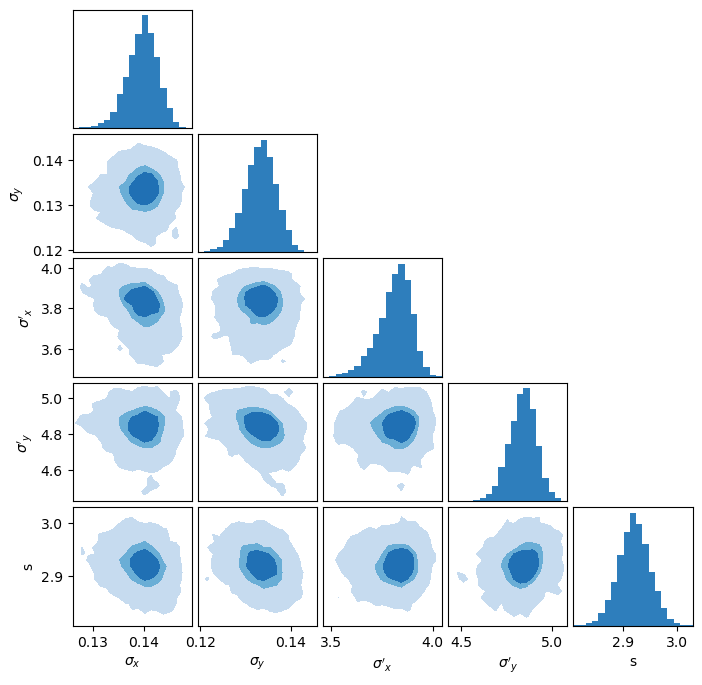

In [22]:
dims = [1,2,3,4,5,]
names = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", "s", "6", "7", "8", "9"]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

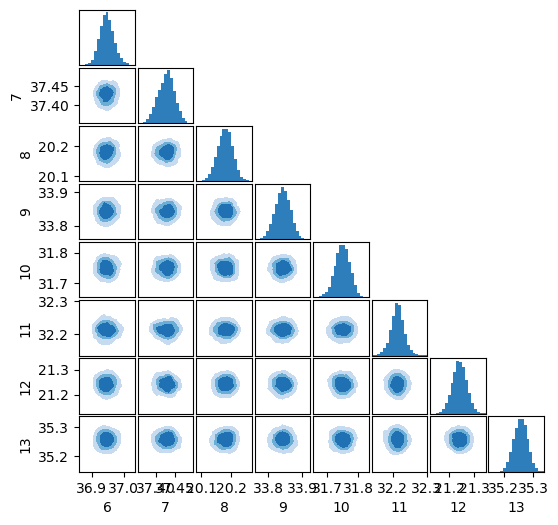

In [23]:
dims = [6,7,8,9,10,11,12, 13]
names = ["6", "7", "8", "9", "10", "11", "12", "13"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

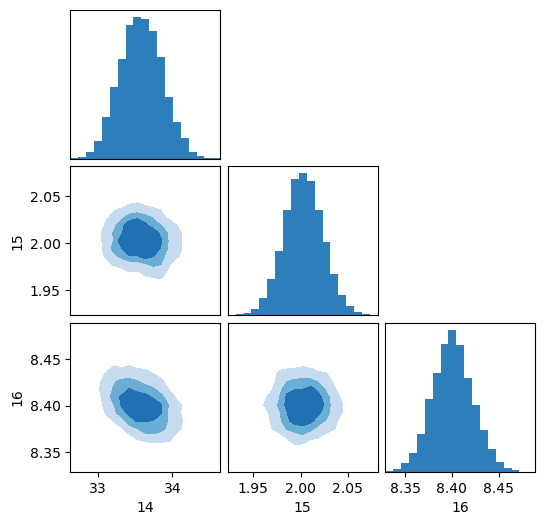

In [24]:
dims = [14,15,16,]
names = [14,15,16,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

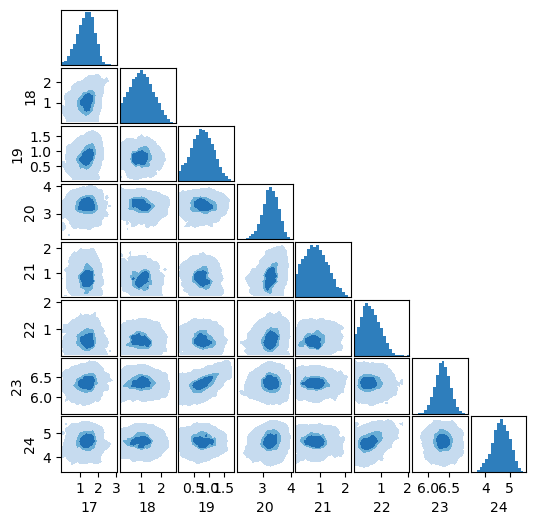

In [25]:
# res

dims = [17,18,19,20,21,22,23,24]
names = [17,18,19,20,21, 22, 23, 24]
levels = [0.1, 0.5, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

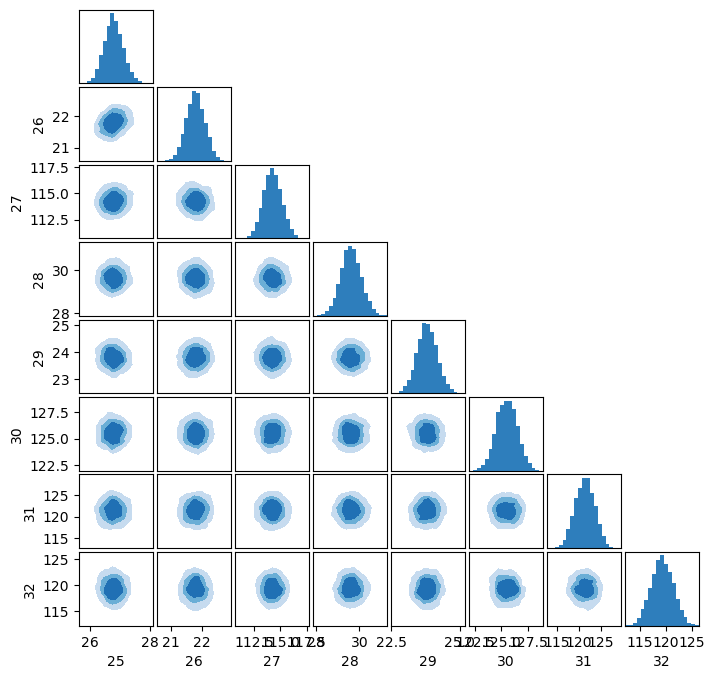

In [26]:
#pix

dims = [25,26,27,28,29, 30, 31, 32]
names = [25,26,27,28,29, 30, 31, 32]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

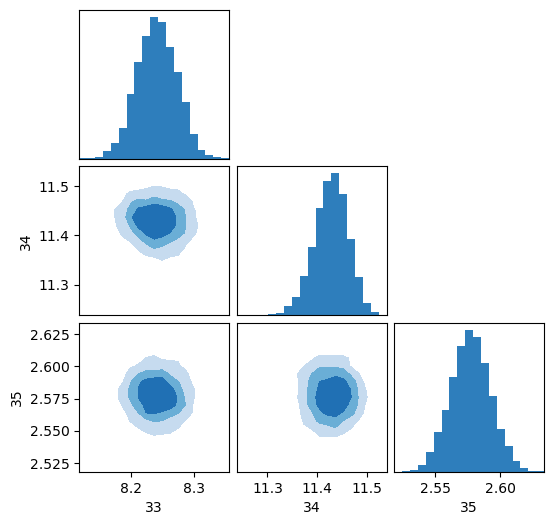

In [27]:
dims = [33, 34, 35]
names = [33, 34, 35]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

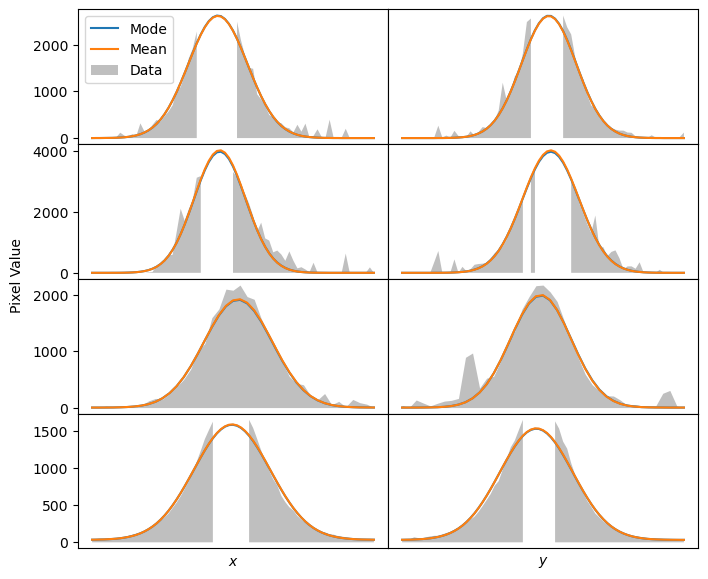

PyObject Text(0.04, 0.5, 'Pixel Value')

In [28]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

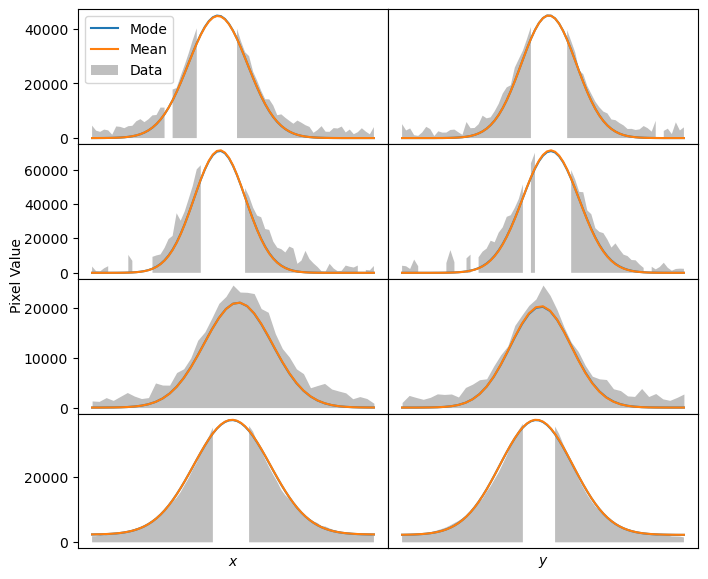

PyObject Text(0.04, 0.5, 'Pixel Value')

In [29]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

In [30]:
params_array = [param_truth, mode(samples)[1], mean(samples)[1]]
colors_array = ["gray", "C0", "C1"]
labels_array = ["Truth", "Mode", "Mean"]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

LoadError: UndefVarError: param_truth not defined

In [ ]:
β = 0.015

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         δ_x = [truncated(Normal(0.0271, 0.0271*β), 0, Inf), truncated(Normal(0.0216, 0.0216*β), 0, Inf), truncated(Normal(0.114, 0.114*β), 0, Inf), truncated(Normal(0.091, 0.091*β), 0, Inf)], 
#         δ_y = [truncated(Normal(0.0305, 0.0305*β), 0, Inf), truncated(Normal(0.0234, 0.0234*β), 0, Inf), truncated(Normal(0.125, 0.125*β), 0, Inf), truncated(Normal(0.0894, 0.0894*β), 0, Inf)], 
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         is_ped = [29 .. 35],
#         is_light_f = [1.9 .. 2.3,],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );


In [ ]:
prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298], 
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        is_ped = [29 .. 35],
        is_light_f = [1.9 .. 2.3,],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );


In [ ]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.25,
    β = 1.5,
    c = 1e-4..1e2,
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 50..150,
    max_nsamples_init = 800,
    max_nsteps_init = 800,
    max_time_init = Inf
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 4000,
    max_nsteps_per_cycle = 4000,
    max_time_per_cycle = Inf,
    max_ncycles = 120
);

algorithm = MetropolisHastings();

In [ ]:
nsamples = 6*10^4
nchains = 4

In [ ]:
@time samples = bat_sample(
    posterior, (nsamples, nchains), algorithm,
    max_nsteps = nsamples,
    max_time = Inf,
    tuning = tuning,
    init = init,
    burnin = burnin,
    convergence = convergence,
    strict = false,
    filter = true
).result;

In [ ]:
mode(samples)[1]
 
#2.11452269382

In [ ]:
dims = [1,2,3,4,5,]
names = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", "s", "6", "7", "8", "9"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [6,7,8,9,10,11,12, 13]
names = ["6", "7", "8", "9", "10", "11", "12", "13"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [14,15,16,17,18,19,20,21]
names = dims
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [22,23,]
names = dims
# levels = [0.1, 0.8, 0.9, 0.95,  1,]
levels = [0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
# Experiment Event: 

images = load("../data/experiment/dataset_2/m2/images.jld2");

event_number = 2

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
)


In [ ]:
plot_cam_crossections([mode(samples)[1],], event, conv_matrices)

In [ ]:
plot_cam_integral([mode(samples)[1],], event, conv_matrices)

In [ ]:
plot_vector = [param_truth, mode(samples)[1],]

plot_envelop_trajectory(plot_vector,  labels = ["Truth", "MCMC Mode"])

In [ ]:
β_min = 0.7
β_max = 1.3

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
        μ_x = [35,35,20,35], 
        μ_y = [35,35,20,35], 
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

# 30 iterationsfro convergence 

In [ ]:
β_min = 0.7
β_max = 1.3

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
        μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
                β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
                β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
                β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
        μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
                β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
                β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
                β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]], 
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

# #40 iterations for convergence 

In [ ]:
β_min = 0.6
β_max = 1.4

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
    
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
    
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
    
        μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
                β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
                β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
                β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
    
        μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
                β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
                β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
                β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]],
    
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
    
        int_coeff  = [ β_min*param_truth.int_coeff[1]..β_max*param_truth.int_coeff[1],
                β_min*param_truth.int_coeff[2]..β_max*param_truth.int_coeff[2],
                β_min*param_truth.int_coeff[3]..β_max*param_truth.int_coeff[3],
                β_min*param_truth.int_coeff[4]..β_max*param_truth.int_coeff[4]], 
    
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    );

# 43 chains for convergence 

# init = MCMCInitStrategy(
#     init_tries_per_chain = 100..208,
#     max_nsamples_init = 600,
#     max_nsteps_init = 600,
#     max_time_init = Inf
# )

# burnin = MCMCBurninStrategy(
#     max_nsamples_per_cycle = 1700,
#     max_nsteps_per_cycle = 1700,
#     max_time_per_cycle = Inf,
#     max_ncycles = 60
# );

# nsamples = 6*10^4
# nchains = 4;

In [ ]:
# resolution + prior AWAKE 

β_min = 0.7
β_max = 1.3

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [truncated(Normal(3.07, 0.5), 0, 5), truncated(Normal(3.95, 0.5), 0, 5), truncated(Normal(2.13, 0.5), 0, 5), truncated(Normal(2.16, 0.5), 0, 5)], 
#         σ_y = [0 , 0 , 0 , 0 ], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], 
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [3.07, 3.95, 2.13, 2.16],
        σ_y = [3.07 , 3.95, 2.13, 2.16], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], 
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [0, 0, 0, 0],
#         σ_y = [0 , 0 , 0 , 0 ], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );


# #40 iterations for convergence 
# res 1: mean([0.0874, 0.0895] ./ [0.0270999, 0.03049999999999997])
#res2: [0.021599999999999397, 0.023400000000000087] ./ [0.0861, 0.0918]
# res 3: mean([0.303, 0.201] ./ [0.11400000000000077, 0.125])
# res4: mean([0.202, 0.189] ./ [0.030303030303030304, 0.02981267596704524] ) / 3

In [ ]:
β = 0.015

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        δ_x = [truncated(Normal(0.0271, 0.0271*β), 0, Inf), truncated(Normal(0.0216, 0.0216*β), 0, Inf), truncated(Normal(0.114, 0.114*β), 0, Inf), truncated(Normal(0.091, 0.091*β), 0, Inf)], 
        δ_y = [truncated(Normal(0.0305, 0.0305*β), 0, Inf), truncated(Normal(0.0234, 0.0234*β), 0, Inf), truncated(Normal(0.125, 0.125*β), 0, Inf), truncated(Normal(0.0894, 0.0894*β), 0, Inf)], 
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

In [ ]:
β = 0.015

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        δ_x = [truncated(Normal(0.0271, 0.0271*β), 0, Inf), truncated(Normal(0.0216, 0.0216*β), 0, Inf), truncated(Normal(0.114, 0.114*β), 0, Inf), truncated(Normal(0.091, 0.091*β), 0, Inf)], 
        δ_y = [truncated(Normal(0.0305, 0.0305*β), 0, Inf), truncated(Normal(0.0234, 0.0234*β), 0, Inf), truncated(Normal(0.125, 0.125*β), 0, Inf), truncated(Normal(0.0894, 0.0894*β), 0, Inf)], 
        int_coeff  = [Normal(35147.44, β*35147.44), Normal(50235.06, β*50235.06), Normal(10096.64, β*10096.64), Normal(33406.9, β*33406.9)],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );



In [ ]:
# β_min = 0.9
# β_max = 1.1

# prior = NamedTupleDist(
#         tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
    
#         ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
    
#         s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
    
#         μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
#                 β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
#                 β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
#                 β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
    
#         μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
#                 β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
#                 β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
#                 β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]],
    
#         σ_x = [0,0,0,0], 
#         σ_y = [0,0,0,0], 
#         δ_x = [ β_min*param_truth.δ_x[1]..β_max*param_truth.δ_x[1],
#                 β_min*param_truth.δ_x[2]..β_max*param_truth.δ_x[2],
#                 β_min*param_truth.δ_x[3]..β_max*param_truth.δ_x[3],
#                 β_min*param_truth.δ_x[4]..β_max*param_truth.δ_x[4]],
    
#         δ_y = [ β_min*param_truth.δ_y[1]..β_max*param_truth.δ_y[1],
#                 β_min*param_truth.δ_y[2]..β_max*param_truth.δ_y[2],
#                 β_min*param_truth.δ_y[3]..β_max*param_truth.δ_y[3],
#                 β_min*param_truth.δ_y[4]..β_max*param_truth.δ_y[4]],
    
#         int_coeff  = [ β_min*param_truth.int_coeff[1]..β_max*param_truth.int_coeff[1],
#                 β_min*param_truth.int_coeff[2]..β_max*param_truth.int_coeff[2],
#                 β_min*param_truth.int_coeff[3]..β_max*param_truth.int_coeff[3],
#                 β_min*param_truth.int_coeff[4]..β_max*param_truth.int_coeff[4]], 
    
#         s_cam = [0.0, 1.478, 15.026, 23.1150],
#     );

# init = MCMCInitStrategy(
#     init_tries_per_chain = 100..200,
#     max_nsamples_init = 2000,
#     max_nsteps_init = 2000,
#     max_time_init = Inf
# )

# burnin = MCMCBurninStrategy(
#     max_nsamples_per_cycle = 5000,
#     max_nsteps_per_cycle = 5000,
#     max_time_per_cycle = Inf,
#     max_ncycles = 45
# );

# algorithm = MetropolisHastings()


In [ ]:
posterior = PosteriorDensity(log_likelihood, prior);

In [ ]:
tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.25,
    β = 1.5,
    c = 1e-4..1e2,
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 120..220,
    max_nsamples_init = 800,
    max_nsteps_init = 800,
    max_time_init = Inf
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 4000,
    max_nsteps_per_cycle = 4000,
    max_time_per_cycle = Inf,
    max_ncycles = 200
);

algorithm = MetropolisHastings()

In [ ]:
nsamples = 6*10^4
nchains = 4

In [ ]:
@time samples = bat_sample(
    posterior, (nsamples, nchains), algorithm,
    max_nsteps = nsamples,
    max_time = Inf,
    tuning = tuning,
    init = init,
    burnin = burnin,
    convergence = convergence,
    strict = false,
    filter = true
).result;

In [ ]:
# BAT.bat_write("test.hdf5", unshaped.(samples))
# CSV.write(SAVE_PATH*file_name_*".csv", output_sp_ms.info)

In [ ]:
# samples = bat_read("../data/sampling_results/Resolution_Effects/wc_resolution.hdf5") 
# samples = varshape(prior).(samples)
# # wcr_samples_uw = bat_sample(wcr_samples, length(wcr_samples)).result;

In [ ]:
# int = bat_integrate(samples)

In [ ]:
mode(samples)[1]

In [ ]:
bat_integrate(samples)

In [ ]:
# BAT.bat_write("../data/sampling_results/Resolution_Effects/wr_px_resolution.hdf5", unshaped.(samples))

In [ ]:
dims = [1,2,3,4,5,]
names = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", "s", "6", "7", "8", "9"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [6,7,8,9,10,11,12, 13]
names = ["6", "7", "8", "9", "10", "11", "12", "13"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [14,15,16,17, 18, 19, 20, 21]
names = ["14", "15", "16", "17", "18", "19", "20", "21"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [22, 23, 24, 25, 26, 27, 28, 29]
names = [22, 23, 24, 25, 26, 27, 28, 29]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
bat_eff_sample_size(unshaped.(samples.v)).result

In [ ]:
bat_eff_sample_size(unshaped.(samples.v)).result ./ length(samples)

In [ ]:
plot_cam_crossections([mode(samples)[1],], event, conv_matrices)

In [ ]:
plot_vector = [param_truth, mode(samples)[1],]

plot_envelop_trajectory(plot_vector,  labels = ["Truth", "MCMC Mode"])

In [ ]:
@show round.(unshaped(std(samples)), sigdigits=3)

In [ ]:
unshaped(std(samples))

In [ ]:
# BAT.bat_write("../data/sampling_results/Resolution_Effects/w-34d-tmp_resolution.hdf5", unshaped.(samples))

# Whitenig: 

In [ ]:
using MultivariateStats

In [ ]:
resamples = bat_sample(samples, length(samples)).result
flat_samples = collect(flatview(unshaped.(resamples.v)))

W = fit(Whitening, flat_samples)

plt.scatter(flat_samples[1,:], flat_samples[2,:])


In [ ]:
smpl_tr = W.W' * (flat_samples .- W.mean) # white samples
plt.scatter(smpl_tr[1,:], smpl_tr[2,:])


In [ ]:
# min_s = minimum(smpl_tr, dims=2)
# max_s = maximum(smpl_tr, dims=2)

# @show min_s, max_s;

In [ ]:
smpl_tr = inv(W.W')*smpl_tr .+ W.mean # back to original space
plt.scatter(smpl_tr[1,:], smpl_tr[2,:])

In [ ]:
β_min = 0.8
β_max = 1.2

minv = [β_min*param_truth.tr_size[1], β_min*param_truth.tr_size[2], β_min*param_truth.ang_spr[1], β_min*param_truth.tr_size[2], β_min*param_truth.s_waist[1]]
maxv = [β_max*param_truth.tr_size[1], β_max*param_truth.tr_size[2], β_max*param_truth.ang_spr[1], β_max*param_truth.ang_spr[2], β_max*param_truth.s_waist[1]]

prior_samples = rand(Product(Uniform.(minv, maxv)), 10^4)

prior_samples = W.W' * (prior_samples .- W.mean)

min_s = minimum(prior_samples, dims=2)
max_s = maximum(prior_samples, dims=2)

@show round.(min_s, sigdigits=2), round.(max_s, sigdigits=2);


In [ ]:
@show W.W

In [ ]:
@show W.mean

In [ ]:
W.W' * ([param_truth.tr_size[1], param_truth.tr_size[2], param_truth.ang_spr[1], param_truth.ang_spr[2], param_truth.s_waist[1]] .- W.mean)

In [ ]:
a1, a2, a3, a4, a5 = W.W' * ([param_truth.tr_size[1], param_truth.tr_size[2], param_truth.ang_spr[1], param_truth.ang_spr[2], param_truth.s_waist[1]] .- W.mean)



In [ ]:
inv(W.W') * [a1, a2, a3, a4, a5] .+ W.mean